### **다층 신경망** 
여러 개의 이미지를 분류하는 다층 신경망을 만들 때 출력층을 하나로 하는 단일 분류, 출력층을 여러 개로 하는 다중 분류로 나눌 수 있다. 출력층에 활성화 함수를 계산한 값의 합이 1이 되면 분류를 하기 편하고 공정하다. 그런데 다중 분류 출력층에서 활성화 함수를 시그모이드 함수로 사용했을 때, 그 결과 값의 합이 1로 나오지 않는다. 따라서 다중 분류에서 출력층의 활성화 함수를 시그모이드 함수로 사용하는 것은 적절하지 않다. 이 문제를 해결하기 위해 소프트 맥스 함수를 사용한다.

### **소프트 맥스 함수**
출력층의 개수가 n개일 때 각 출력층의 선형 출력값 z_n이라고 하자. 소프트 맥스 함수는 각 선형 출력값을 exponetial 지수 함수에 적용해 계산한다. 
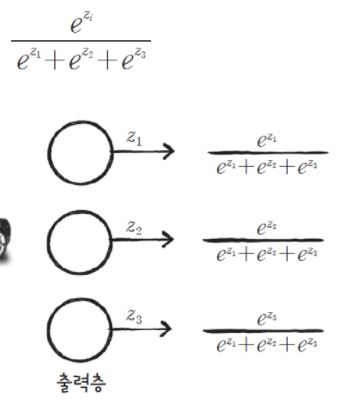 

각 소프트맥스 함수를 적용한 값의 합은 1이 된다.

### **손실 함수**
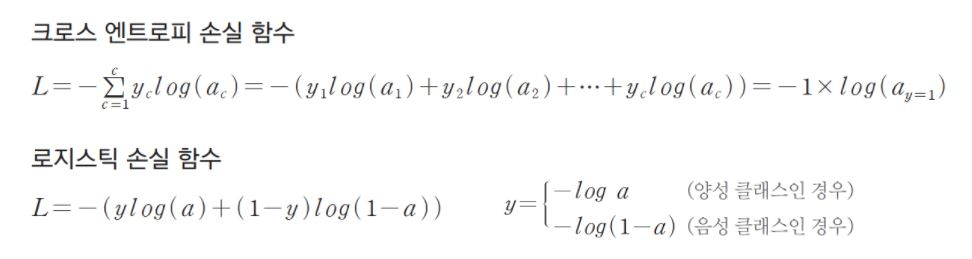

다중 분류를 위한 손실함수인 크로스엔트로피 함수는 로지스틱 분류의 로지스틱 손실함수(이진 크로스 엔트로피 손실함수라고도 불린다.)와 아주 유사하다. 위 식에서 a는 소프트 맥스의 출력값이다. 크로스 엔트로피 손실함수를 미분해보자.
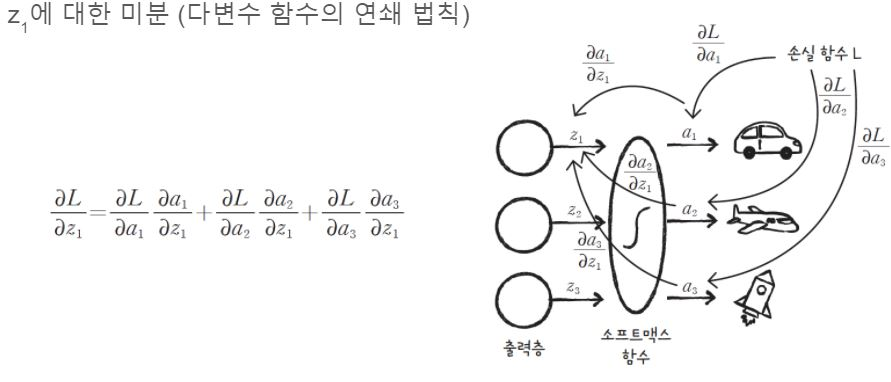
#### a에 대한 손실함수L의 편미분
ai에 대한 미분 = -yi/ai
#### z1에 대한 a1의 편미분
a1(1 - a1)
#### z1에 대한 a2, a3의 편미분
-(ai x a1)   *i는 2와 3*
#### z1에 대한 손실함수L의 편미분
-(y - a)

In [3]:
import numpy as np

In [6]:
class MultiClassNetwork:
  def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        self.units = units         # 은닉층의 뉴런 개수
        self.batch_size = batch_size     # 배치 크기
        self.w1 = None             # 은닉층의 가중치
        self.b1 = None             # 은닉층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.a1 = None             # 은닉층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

  def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1        # 첫 번째 층의 선형 식을 계산합니다
        self.a1 = self.sigmoid(z1)               # 활성화 함수를 적용합니다
        z2 = np.dot(self.a1, self.w2) + self.b2  # 두 번째 층의 선형 식을 계산합니다.
        return z2

  def backprop(self, x, err):
        m = len(x)       # 샘플 개수
        # 출력층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        # 시그모이드 함수까지 그래디언트를 계산합니다.
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        # 은닉층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad

  def sigmoid(self, z):
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))              # 시그모이드 계산
        return a

  def softmax(self, z):         # 소프트맥스 함수
    z = np.clip(z, -100, None)  # 안전한 지수 계산을 위해
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)  # np.sum(exp_z, axis=1)으로 n x 3 행렬 벡터를 1 x n 행 벡터로 변환 행렬 계산을 위해 reshape(-1, 1)로 n x 1 열 벡터로 변환

  def init_weights(self, n_features, n_classes):
        self.w1 = np.random.normal(0, 1, (n_features, self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)                        # 은닉층의 크기
        self.w2 = np.random.normal(0, 1, (self.units, n_classes))   # (은닉층의 크기, 클래스 개수)
        self.b2 = np.zeros(n_classes)

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        np.random.seed(42)
        self.init_weights(x.shape[1], y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            loss = 0
            print('.', end='')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            for x_batch, y_batch in self.gen_batch(x, y):
                a = self.training(x_batch, y_batch)
                # 안전한 로그 계산을 위해 클리핑합니다.
                a = np.clip(a, 1e-10, 1-1e-10)
                # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
                loss += np.sum(-y_batch*np.log(a))
            self.losses.append((loss + self.reg_loss()) / len(x))
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)

  # 미니배치 제너레이터 함수
  def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니배치 횟수
        if length % self.batch_size:
            bins += 1                    # 나누어 떨어지지 않을 때
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        # permutation은 interger를 np.arange를 통해 array로 만들어준 값을 셔플하여 나타내어 준다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
  def training(self, x, y):
        m = len(x)                # 샘플 개수를 저장합니다.
        z = self.forpass(x)       # 정방향 계산을 수행합니다.
        a = self.softmax(z)       # 활성화 함수를 적용합니다.
        err = -(y - a)            # 오차를 계산합니다.
        # 오차를 역전파하여 그래디언트를 계산합니다.
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 그래디언트에서 페널티 항의 미분 값을 뺍니다
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        # 은닉층의 가중치와 절편을 업데이트합니다.
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편을 업데이트합니다.
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
   
  def predict(self, x):
        z = self.forpass(x)          # 정방향 계산을 수행합니다.
        return np.argmax(z, axis=1)  # 가장 큰 값의 인덱스를 반환합니다.
    
  def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

  def reg_loss(self):
        # 은닉층과 출력층의 가중치에 규제를 적용합니다.
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

  def update_val_loss(self, x_val, y_val):
      z = self.forpass(x_val)
      a = self.softmax(z)
      a = np.clip(a, 1e-10, 1-1e-10)
      val_loss = np.sum(-y_val*np.log(a))
      self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [7]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [8]:
# 데이터 준비
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print(x_train_all.shape, y_train_all.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)


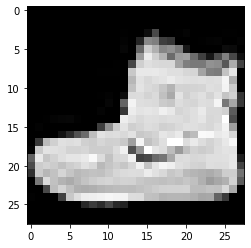

In [12]:
import matplotlib.pyplot as plt
plt.imshow(x_train_all[0], cmap='gray')
plt.show()

In [13]:
print(y_train_all[:10])

[9 0 0 3 0 2 7 2 5 5]


In [14]:
class_names = ['티셔츠/윗도리', '바지', '스웨터', '드레스', '코트', '샌들', '셔츠', '스니커즈', '가방', '앵클부츠']
print(class_names[y_train_all[0]])

앵클부츠


In [15]:
np.bincount(y_train_all)   # 각 클래스의 빈도수 계산

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [20]:
# 훈련 세트와 검증 세트 준비
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
np.bincount(y_train) # 훈련 세트의 각 클래스 빈도수 계산

array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800])

In [21]:
np.bincount(y_val) # 검증 세트의 각 클래스 빈도수 계산

array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200])

In [22]:
x_train = x_train / 255
x_val = x_val / 255
x_train = x_train.reshape(-1, 784)  # 3차원 배열을 2차원 배열로 변환, 가로(28)와 세로(28)의 곱(784)이 열의 개수
x_val = x_val.reshape(-1, 784)      # 3차원 배열을 2차원 배열로 변환, 가로(28)와 세로(28)의 곱(784)이 열의 개수
print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


### **원-핫 인코딩**
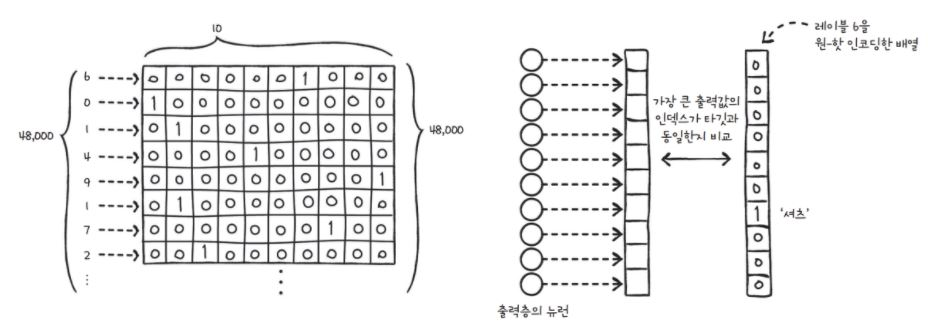

0으로 초기화된 배열에 타깃의 값에 해당하는 인덱스 자리에 1을 넣는다. 한 타깃의 값은 한 행으로 표현한다. 

In [25]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)
print(y_train_encoded.shape, y_val_encoded.shape)

(48000, 10) (12000, 10)


In [27]:
print(y_train[0], y_train_encoded[0])  #(기존 훈련 세트, 원-핫 인코딩 후 훈련 세트)

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


........................................

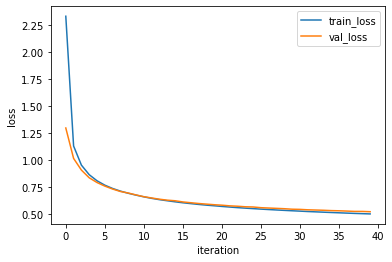

In [29]:
# MultiClassNetwork로 다중 분류 신경망 훈련하기
fc = MultiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=40)
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [30]:
fc.score(x_val, y_val_encoded)

0.8150833333333334